<a href="https://colab.research.google.com/github/shindeal/Anjali/blob/main/BigDataFinalProject2022_ML_Clustering_silhouette_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setting up PySpark in Colab**


In [1]:
!apt-get install openjdk-8-jdk-headless


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 67 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jre-headless amd64 8u312-b07-0ubuntu1~18.04 [28.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jdk-headless

In [2]:
!wget https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz


--2022-05-18 08:48:49--  https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
Resolving archive.apache.org (archive.apache.org)... 138.201.131.134, 2a01:4f8:172:2ec5::2
Connecting to archive.apache.org (archive.apache.org)|138.201.131.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 272637746 (260M) [application/x-gzip]
Saving to: ‘spark-3.2.1-bin-hadoop2.7.tgz’

spark-3.2.1-bin-had 100%[===================>] 260.01M  3.91MB/s    in 1m 43s  

2022-05-18 08:50:33 (2.52 MB/s) - ‘spark-3.2.1-bin-hadoop2.7.tgz’ saved [272637746/272637746]



In [3]:
!tar xf /content/spark-3.2.1-bin-hadoop2.7.tgz


In [4]:
!pip install -q findspark


In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

In [6]:
import findspark
findspark.init()
findspark.find()

'/content/spark-3.2.1-bin-hadoop2.7'

In [7]:
import pyspark
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[*]').appName('Revenue_Prediction').getOrCreate()

In [9]:
adclicks_df = pd.read_csv('ad-clicks.csv')
adclicks_df['adCount'] = 1
adclicks_df.head(1)


,timestamp,txId,userSessionId,teamId,userId,adId,adCategory,adCount
0,2016-05-26 15:13:22,5974,5809,27,611,2,electronics,1


In [10]:
gameclicks_df = pd.read_csv('game-clicks.csv')
gameclicks_df['clickCount'] = gameclicks_df['isHit'].apply(lambda x: 0 if x == 0 else 1)

In [11]:
gameclicks_df.head(1)

,timestamp,clickId,userId,userSessionId,isHit,teamId,teamLevel,clickCount
0,26/05/2016 15:06,105,1038,5916,0,25,1,0


In [12]:
buyclicks_df = pd.read_csv('buy-clicks.csv')

In [13]:
buyclicks_df.head(1)

,timestamp,txId,userSessionId,team,userId,buyId,price
0,2016-05-26 15:36:54,6004,5820,9,1300,2,3.0


**feature selection**

In [14]:
user_purchases = buyclicks_df[['userId','price']] #select only userid and price
user_purchases.head(2)

,userId,price
0,1300,3.0
1,868,10.0


In [15]:
user_adclicks = adclicks_df[['userId','adCount']] #select only userId, adcount
user_adclicks.head(2)


,userId,adCount
0,611,1
1,1874,1


In [16]:
##select only userId, Gameclickcount if ishit=0 then 0 else 1
user_gameclicks = gameclicks_df[['userId','clickCount']] 
user_gameclicks.head(2)

,userId,clickCount
0,1038,0
1,1099,0


In [17]:
ads_per_user = user_adclicks.groupby('userId').sum() #df created as per user and totalclicks made
ads_per_user = ads_per_user.reset_index()
ads_per_user.columns = ['userId', 'totalAdClicks'] #rename the columns
ads_per_user.head(5)

,userId,totalAdClicks
0,1,44
1,8,10
2,9,37
3,10,19
4,12,46


In [18]:
game_clicks_per_user = user_gameclicks.groupby('userId').sum() #df created as per user and TotalGameclick made
game_clicks_per_user = game_clicks_per_user.reset_index()
game_clicks_per_user.columns = ['userId', 'totalGameClicks'] 
game_clicks_per_user.head(5)

,userId,totalGameClicks
0,0,143
1,1,96
2,2,22
3,6,16
4,8,38


In [19]:
revenue_per_user = user_purchases.groupby('userId').sum() #df created with userid and revenue made
revenue_per_user = revenue_per_user.reset_index()
revenue_per_user.columns = ['userId', 'revenue'] #rename the columns
revenue_per_user.head(5)

,userId,revenue
0,1,21.0
1,8,53.0
2,9,80.0
3,10,11.0
4,12,215.0


In [20]:
combined_df = ads_per_user.merge(game_clicks_per_user, on='userId') #userId, adCount, clickCount
combined_df = combined_df.merge(revenue_per_user, on='userId') #userId, adCount, clickCount, price
combined_df.head(5) #display how the joined table

,userId,totalAdClicks,totalGameClicks,revenue
0,1,44,96,21.0
1,8,10,38,53.0
2,9,37,62,80.0
3,10,19,340,11.0
4,12,46,92,215.0


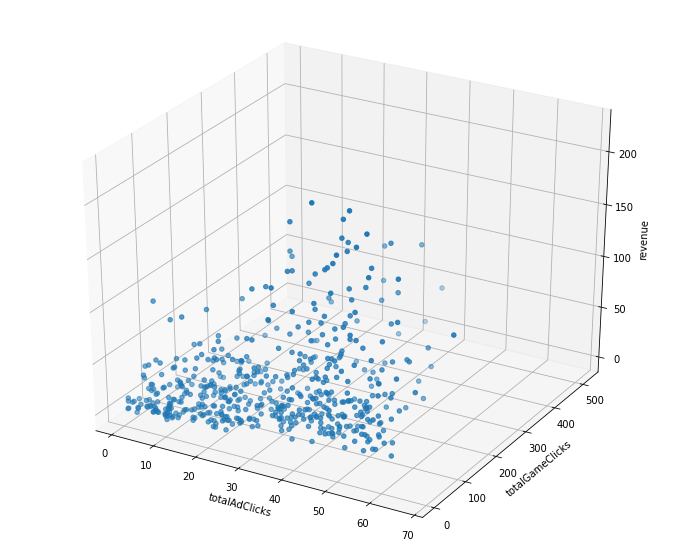

In [21]:
combined_plot = plt.figure(figsize=(12,10)).gca(projection='3d')
combined_plot.scatter(combined_df.totalAdClicks, combined_df.totalGameClicks, combined_df.revenue)
combined_plot.set_xlabel('totalAdClicks')
combined_plot.set_ylabel('totalGameClicks')
combined_plot.set_zlabel('revenue')
plt.show()

**Training the model**

In [22]:
# we have removed the userid from the combined_df per user
combined_model_data= combined_df[ ["totalAdClicks", "totalGameClicks","revenue"]]
combined_model_data.head()

,totalAdClicks,totalGameClicks,revenue
0,44,96,21.0
1,10,38,53.0
2,37,62,80.0
3,19,340,11.0
4,46,92,215.0


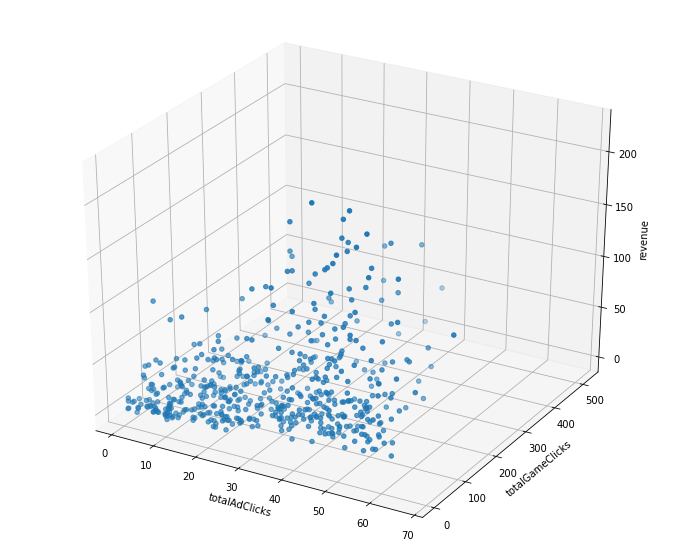

In [28]:
#Final model with 3 dataset
combined_plot = plt.figure(figsize=(12,10)).gca(projection='3d')
combined_plot.scatter(combined_model_data.totalAdClicks, combined_model_data.totalGameClicks, combined_model_data.revenue)
combined_plot.set_xlabel('totalAdClicks')
combined_plot.set_ylabel('totalGameClicks')
combined_plot.set_zlabel('revenue')
plt.show()

**Converting pandas df to spark df to add into vector assembler**

In [102]:
combined_spark_df = spark.createDataFrame(combined_model_data)
from pyspark.ml.feature import VectorAssembler
vecAssembler = VectorAssembler(inputCols=["totalAdClicks", "totalGameClicks","revenue"], outputCol="features")
assembled_data = vecAssembler.transform(combined_spark_df)
assembled_data.show()

+-------------+---------------+-------+-----------------+
|totalAdClicks|totalGameClicks|revenue|         features|
+-------------+---------------+-------+-----------------+
|           44|             96|   21.0| [44.0,96.0,21.0]|
|           10|             38|   53.0| [10.0,38.0,53.0]|
|           37|             62|   80.0| [37.0,62.0,80.0]|
|           19|            340|   11.0|[19.0,340.0,11.0]|
|           46|             92|  215.0|[46.0,92.0,215.0]|
|           16|             48|   20.0| [16.0,48.0,20.0]|
|           15|             20|    2.0|  [15.0,20.0,2.0]|
|           52|             58|   19.0| [52.0,58.0,19.0]|
|            9|            177|    2.0|  [9.0,177.0,2.0]|
|           10|              7|    4.0|   [10.0,7.0,4.0]|
|           20|             25|   75.0| [20.0,25.0,75.0]|
|           34|             96|   95.0| [34.0,96.0,95.0]|
|           29|            176|   30.0|[29.0,176.0,30.0]|
|           46|             77|   26.0| [46.0,77.0,26.0]|
|           38

In [111]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(2)

+-------------+---------------+-------+----------------+--------------------+
|totalAdClicks|totalGameClicks|revenue|        features|        standardized|
+-------------+---------------+-------+----------------+--------------------+
|           44|             96|   21.0|[44.0,96.0,21.0]|[2.89162773065283...|
|           10|             38|   53.0|[10.0,38.0,53.0]|[0.65718812060291...|
+-------------+---------------+-------+----------------+--------------------+
only showing top 2 rows



In [112]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    score=evaluator.evaluate(output)
    silhouette_score.append(score)
    print("Silhouette Score:",score)

Silhouette Score: 0.4702809635749889
Silhouette Score: 0.5108369902860456
Silhouette Score: 0.34856545012430123
Silhouette Score: 0.5214872320474581
Silhouette Score: 0.5383397508378897
Silhouette Score: 0.521851289681548
Silhouette Score: 0.4747969378235049
Silhouette Score: 0.46813575269480784


Text(0, 0.5, 'cost')

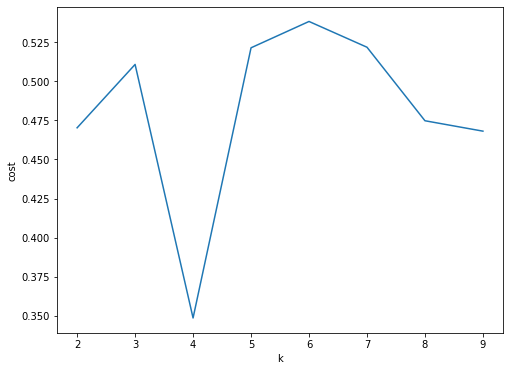

In [113]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [114]:
#fitting the best optimal number received from silhouette score i.e.6
final_clustering=KMeans(featuresCol='standardized', k=6)
KMeans_fit=final_clustering.fit(data_scale_output)
clusters_output=KMeans_fit.transform(data_scale_output)

In [121]:
#notice the last column [prediction]
clusters_output.show(5)

+-------------+---------------+-------+-----------------+--------------------+----------+
|totalAdClicks|totalGameClicks|revenue|         features|        standardized|prediction|
+-------------+---------------+-------+-----------------+--------------------+----------+
|           44|             96|   21.0| [44.0,96.0,21.0]|[2.89162773065283...|         0|
|           10|             38|   53.0| [10.0,38.0,53.0]|[0.65718812060291...|         4|
|           37|             62|   80.0| [37.0,62.0,80.0]|[2.43159604623079...|         3|
|           19|            340|   11.0|[19.0,340.0,11.0]|[1.24865742914554...|         5|
|           46|             92|  215.0|[46.0,92.0,215.0]|[3.02306535477342...|         1|
+-------------+---------------+-------+-----------------+--------------------+----------+
only showing top 5 rows



In [119]:
clusters_output.createOrReplaceTempView("clusters_output")
query= spark.sql("select totalAdClicks,totalGameClicks,revenue,prediction from clusters_output group by totalAdClicks,totalGameClicks,revenue,prediction")
query.count()
query.show()

+-------------+---------------+-------+----------+
|totalAdClicks|totalGameClicks|revenue|prediction|
+-------------+---------------+-------+----------+
|           56|            103|  160.0|         1|
|           13|             70|   22.0|         4|
|           56|             28|   45.0|         0|
|           33|             73|   11.0|         0|
|           55|             62|   32.0|         0|
|           10|             14|   13.0|         4|
|           52|             68|  165.0|         1|
|            4|             27|   20.0|         4|
|           14|             94|    8.0|         2|
|           12|             13|    3.0|         4|
|           25|             24|   14.0|         4|
|           44|             69|  170.0|         1|
|           55|             57|   60.0|         0|
|           22|             21|   23.0|         4|
|           25|             56|   40.0|         3|
|           31|             73|   18.0|         2|
|           36|             73|

In [122]:
#from below code it is clear that prediction with 6 clusters is formed
query1= spark.sql("select prediction, count(*) as cluster_data from clusters_output group by prediction order by prediction asc ")
query1.show()

+----------+------------+
|prediction|cluster_data|
+----------+------------+
|         0|         153|
|         1|          42|
|         2|          75|
|         3|          72|
|         4|         173|
|         5|          28|
+----------+------------+



**Convert the cluster output to pandas for visualization**

In [91]:
final_model_cluster = clusters_output.toPandas()
final_model_cluster.head(1)

,totalAdClicks,totalGameClicks,revenue,features,standardized,prediction
0,44,96,21.0,"[44.0, 96.0, 21.0]","[2.8916277306528366, 1.383306803626919, 0.5094...",0


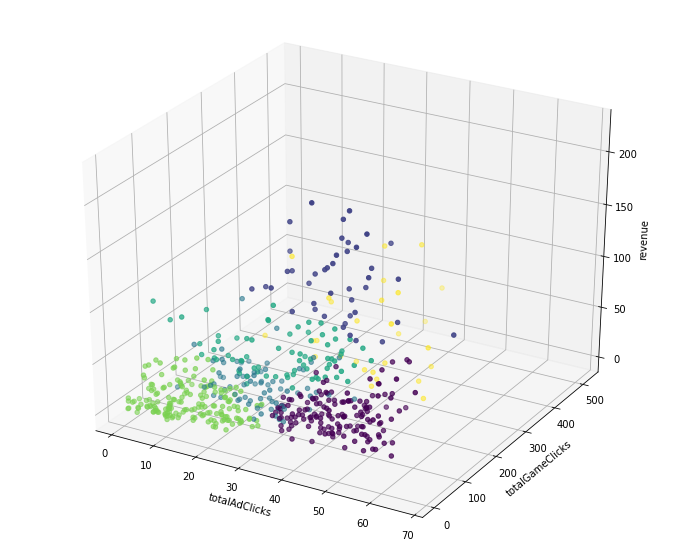

In [123]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(final_model_cluster.totalAdClicks, final_model_cluster.totalGameClicks, final_model_cluster.revenue, c=final_model_cluster.prediction)
threedee.set_xlabel('totalAdClicks')
threedee.set_ylabel('totalGameClicks')
threedee.set_zlabel('revenue')
plt.show()

**show the centres of cluster**

In [124]:
centers = KMeans_fit.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[2.93044153 1.13157669 0.65092393]
[2.81026158 1.41487035 3.56550214]
[1.50214428 1.72089954 0.46753797]
[2.1282092  0.97865798 1.82142233]
[0.88491145 0.42197895 0.40619798]
[2.34397096 4.21812512 1.0924657 ]


In [125]:
centers

[array([2.93044153, 1.13157669, 0.65092393]),
 array([2.81026158, 1.41487035, 3.56550214]),
 array([1.50214428, 1.72089954, 0.46753797]),
 array([2.1282092 , 0.97865798, 1.82142233]),
 array([0.88491145, 0.42197895, 0.40619798]),
 array([2.34397096, 4.21812512, 1.0924657 ])]